# 13. 메모리 네트워크
- 추론하는 인공지능 만들기

### 학습 목표
1. 추론이 필요한 Q&A task와 메모리의 관계를 이해한다.
2. 메모리 구조를 사용하는 메모리 네트워크에 대해서 이해한다.
3. End-to-End Memory Network 전후의 발전사를 알아본다.

## 13.2  bAbI 프로젝트
### bAbI 프로젝트
2015년 페이스북 AI 연구소에서 시작한 bAbI 프로젝트. __모델의 언어 이해 및 추론 능력을 테스트__ 하는 이 프로젝트는 총 20개의 태스크가 있으며 10,000개의 훈련 데이터 쌍 / 1,000개의 테스트 데이터 쌍으로 구성된다.

- [bAbI 프로젝트 공식 홈페이지](https://research.fb.com/downloads/babi/)

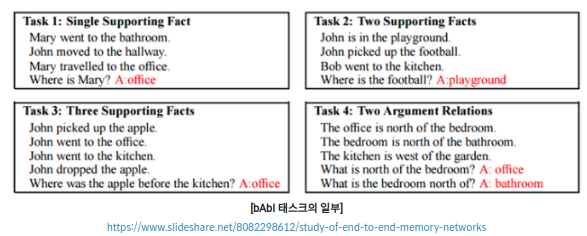

"스토리"(문장들의 모음)을 들려주고 질문을 던지면 인공지능이 스토리로부터 정답을 맞춘다.

### bAbI 데이터셋에 대한 이해
- bAbI 프로젝트의 데이터셋의 형식

```python
ID text
ID text
ID text
ID question[tab]answer[tab]supporting_fact ID.
...
```

- ID: 각 문장의 번호, 스토리가 시작될 때 1번으로 시작함. 

``` python
1 Sandra travelled to the kitchen. 
2 Sandra travelled to the hallway. 
3 Mary went to the bathroom. 
4 Sandra moved to the garden. 

5 Where is Sandra?      Garden         4
```
위의 4개의 문장으로 구성된 스토리로부터 질문과 정답이 나온다. 레이블에 해당하는 Garden은 질문 뒤에 tab 하나를 두고 등장한다. Garden 옆의 숫자 4는 __Supporting fact__ 로서 실제 정답이 주어진 스토리에서 몇 번 id의 문장에서 있었는지 알려준다. 실제로 인공지능의 훈련 단계에서는 supporting fact는 학습하지 않는 것이 원칙이다. 

- 실제 데이터셋

```python

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary?        bathroom        1
4 Daniel went back to the hallway.
5 Sandra moved to the garden.
6 Where is Daniel?      hallway         4
7 John moved to the office.
8 Sandra journeyed to the bathroom.
9 Where is Daniel?      hallway         4
10 Mary moved to the hallway.
11 Daniel travelled to the office.
12 Where is Daniel?     office          11
13 John went back to the garden.
14 John moved to the bedroom.
15 Where is Sandra?     bathroom        8
1 Sandra travelled to the office.
2 Sandra went to the bathroom.
3 Where is Sandra?      bathroom        2
```

첫 번째 스토리는 ID가 15번, 중간에 질문은 3, 6, 9, 11, 15번(총 5번) 나옴. 질문이 나와도 스토리와 질문은 계속 이어진다. 두 번째 스토리가 시작되면 ID가 1번부터 시작된다. 데이터셋의 규모는 1만여개.

### SQuAD와 bAbI 비교
모델의 언어 능력을 다루는 가장 대표적인 벤치마크 데이터셋에는 [ SQuAD(Stanford Question Answering Dataset)](https://rajpurkar.github.io/SQuAD-explorer/)

- SQuAD 데이터셋   
지문(context), 질문(question), 답변(answer)를 하나로 묶은 형태의 Q&A 태스크로 구성. 10만개 이상의 지문-질문-답변 세트. 2018년에 나온 SQuAD의 경우 지문의 길이가 블로그나 위키피디아 아티클 하나의 길이이다.

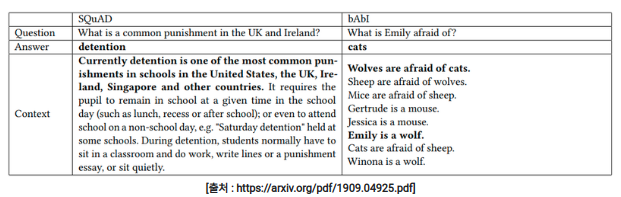

- SQuAD 데이터셋 - Reading Comprehension Dataset              
context 문장의 의미를 정확히 해석하지 않아도 question 문장과의 'word matching'과 'entity resolution'만으로도 정답을 맞출 수 있다. 즉 문장의 구조와 패턴을 충분히 학습한 언어 모델 네트워크라면 질문과 지문을 비교해 쉽게 정답 단어의 포지션을 짚어낼 수 있다.          
용도: 단답형 질의응답 챗봇

- bAbl 데이터셋 - Multi-hop Reading Dataset           
패턴의 유사성만으로는 답을 찾을 수 없고, 'Emily'→'wolf'→'afraid of cat'의 연역적 추론을 거쳐서 답('cat')을 찾을 수 있다.         
용되: 사용자와 지속적으로 대화의 맥락을 이어나가면서 대화 도중 주고받은 정보를 재활용하여 커뮤니케이션할 수 있는 챗봇. 

### Memory의 필요성
- Multi-hop Reasoning 능력    
과거의 정보와 지식을 활용해서 연역적 추론을 통해 새로운 결론에 이를 수 있는 능력 -> 모델이 과거의 정보와 지식을 저장해 두는 저장소인 메모리(memory)가 필요하다. 

## 13-3. 메모리 네트워크가 나오기까지
### LSTM as a Memory Network
- LSTM(Long Short-term Memory)와 Vanilla RNN과의 차이    
```hidden_state``` 와 ```cell_state```
   - ```cell_state```: 단기적인(short-term) 내부(internal) 메모리 역할을 하면서 입력에 따라 달라지는 ```hidden_state``` 정보를 취사선택해서 저장한다. 
   - 아래의 그림에서 ```cell_state```(내부 메모리)는 메모리 블록 ```m```으로 표현, 메모리 관리에 해당하는 빨간색으로 강조

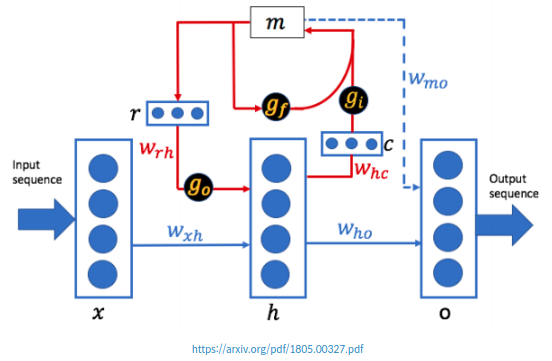

LSTM은 input 및 이전 hidden_state 정보를 이용해 cell_state(메모리)를 업데이트하고 업데이트된 메모리를 반영해 이번 스텝의 hidden_state를 결정하는 구조이다. 

- 참고: [Colah의 유명한 LSTM 정리](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)          

LSTM은 bAbl 태스크같이 메모리가 필요한 추론 문제를 해결할 때 가장 기본적인 베이스인 모델이 될 수 있다. 따라서 많은 논문에서 추론 문제를 풀 때의 비교 대상 베이스라인으로 LSTM을 언급하는 것을 볼 수 있다. 그러나 LSTM에는 단기 메모리(short-term memory)와 같은 여러 가지 한계점이 있다. 즉 장기의존성 문제의 제약에서 자유롭지 못하고 __추론에 필요한 과거 정보를 유실__ 한다. 

### Neural Turing Machine
2014년에 발표된 딥마인드사의 Neural Turing Machine(이하 NTM) (https://arxiv.org/pdf/1410.5401.pdf) 논문. NTM은 아래 그림과 같이 단기 메모리 ```m1```을 가진 기존의 LSTM 구조에 외부 장기 메모리 ```m2```를 하나 더 둔 구조이다. 

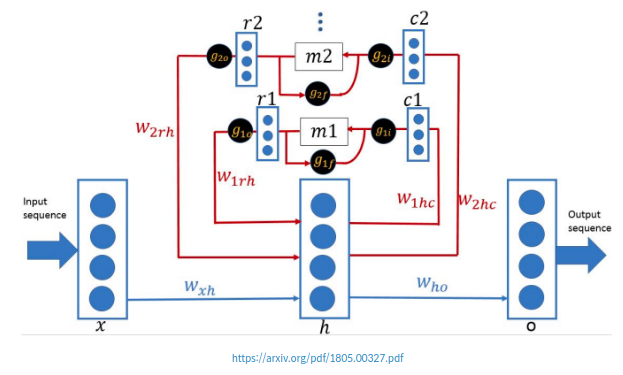

LSTM의 외부에 메모리를 하나 더 두어도 기본적인 LSTM의 논리에는 차이가 없다. LSTM이 Controller가 되어 input 및 이전 hidden_state 정보를 이용해 내부 메모리 ```m1``` 및 외부 메모리 ```m2```를 업데이트한다. 업데이트된 내부 및 외부 메모리 정보가 다시 이번 스텝의 hidden_state를 업데이트한다. 

위와 같이 Controller의 외부에 외부 메모리를 추가하는 Memory Network의 구조를 __Memory Augmented Neural Network__ 이라고 한다. NTM은 이런 구조를 End-to-End로 구현하는 아이디어를 제시하고 구현을 토앻 입중해 보였다는 점에서 큰 의의를 가진다. 

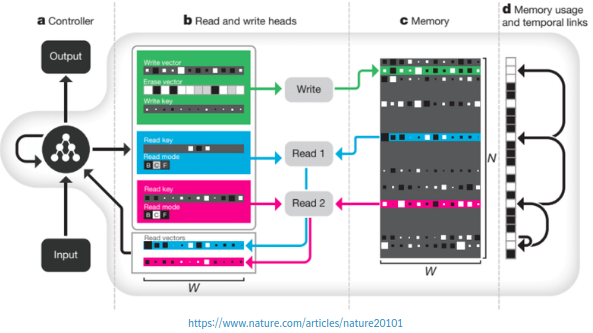

위 그림은 딥마인드에서 2016년 네이처지에 발표한 [Hybrid computing using a neural network with dynamic external memory](https://www.nature.com/articles/nature20101)라는 논문에서 소개된 __Differential Neural Computer(DNC)__ 라는 모델 구조이다. 이 논문은 2014년의 __NTM 구조를 계승하면서도 메모리 관리 로직을 크게 개선__ 하여 bAbl 태스크의 평균 오류를 3.8% 수준으로 낮춰 큰 관심을 끌었다. NTM 논문은 아이디어를 제공했지만 실제로 추론이 가능한 성능은 입중하지 못했기 때문이다. 

```C Memory``` 파트는 Controller로부터 나온 연결이 전체 외부 메모리 중 일부분(현재의 input 및 이전 hidden_state와 Read/Write 상황에 밀접하게 관련있는)만을 참조하거나 업데이트한다. 이것이 ```m1``` 내부 메모리와 ```m2``` 외부 메모리의 결정적인 차이이다. __외부 메모리는 관련 부분만 참조 및 업데이트__ 되고 나머지 부분은 오랫동안 변형 없이 잘 보관되어야 하며, 이것이 장기 기억을 보존하기 위한 필수 요소이다. 

따라서 Memory Augmented Neural Network 구조에서는 __장기 메모리의 어느 부분이 현재 state와 밀접하게 관련이 있는지를 정확하게 파악__ 하는 것이 핵심이며, 그것이 바로 __differentiable attention mechanism__ 이다. 

## 13-4. Memory Network
- 자연어처리 분야에서 중요한 논문이 많이 발표된 2014년
  - NTM
  - Attention 개념이 처음 발표:  [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf). End-to-End Attentional Encoder-Decoder 구조(당시에 불린 이름 RNNsearch)
  - [Memory Network](https://arxiv.org/pdf/1410.3916.pdf): Facebook AI Research (중요!)
  
2014년에 발표한 두 논문(NTM, RNNsearch)에서 인사이트를 얻어 2015년에 __End-to-End Memory Network__ 를 발표해 bAbl task 를 오류율 7.5%까지 낮추는 성과를 냈다. DNC가 2016년에 오류율을 3.8%로 낮추지만 End-to-End Memory Network는 90% 이상의 bAbl task 정확도를 거든 첫 번째 모델로, Memory Network의 가장 기본적인 베이스라인 모델로 여겨진다.

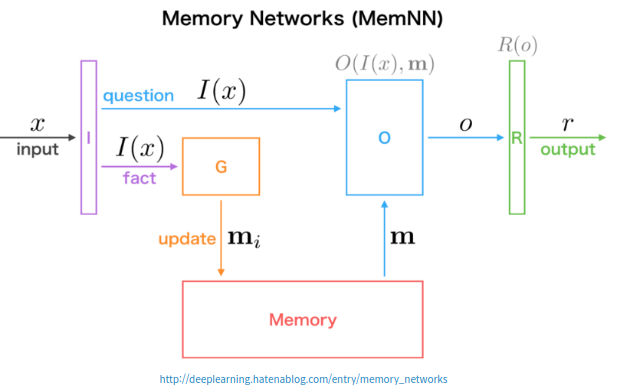

Memory Network는 4개의 컴포넌트로 구성되어 있다. Input을 반영해 외부 메모리를 업데이트하고, 업데이트된 외부 메모리를 토대로 새로운 output 상태를 생성하는 로직은 Memory Augmented Neural Network의 일반적 논리와 동일한다.

- 전체 구성    
  - ```I```(Input feature map): 입력 텍스트 x를 Word2Vec 등 임베딩 모듈을 사용해 내부적인 feature representation으로 변환.
  - ```G```(Generalization): 새로운 입력을 반영해 외부 메모리를 업데이트함. memory를 다음 기회에 사용할 수 있도록 general한 형태로 업데이트.
  - ```O```(Output feature map): 입력의 feature representation I(x)와 외부 메모리를 함께 참조해 새로운 output을 리턴함.
  - ```R```(Response): 새로운 ouuput을 원하는 포맷(주로 텍스트)으로 변환해 출력. 
  
이 당시에는 외부 메모리를 둔다는 개념은 떠올렸지만 End-to-End로 엮지 못하고 4개의 컴포넌트로 분리되어 있었다. 그래서 Memory에는 input feature map이 그대로 반영되었고, 기존 memory와 새로운 입력의 feature와의 관련성 $s(x,y)$는 다음과 같이 수식으로 계산되어 결정되었다. 이를 최대화하는 방식으로 response $r$이 결정되는데, 이런 방식은 미분 불가능한 hard-attention 빙식으로 End-to-End로 구성할 수 없었다.

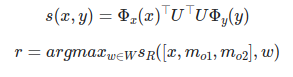

## 13-5. End-to-End Memory Network
- 2015년 페이스북 AI 리서치의 논문 [End to End Memory Networks](https://arxiv.org/pdf/1503.08895)에서 제안된 메모리 네트워크

- 참고 
  - [질의응답을 위한 딥러닝 모델인 메모리 네트워크 정리](http://aidev.co.kr/chatbotdeeplearning/5925)
  - [인공지능을 위한 머신러닝 알고리즘 11강 메모리 네트워크 | T아카데미](https://www.youtube.com/watch?v=vDQf7lcenfI)

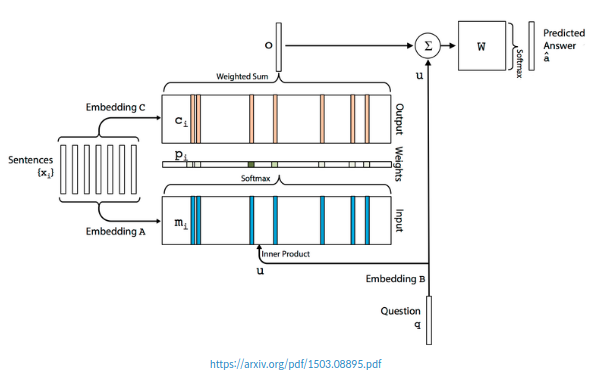

- 변수와 하이퍼파라미터 정의

```python
story_max_len = 68 # 스토리의 길이
question_max_len = 4 # 질문의 길이
embed_size = 50 # Embedding A와 Embedding C의 임베딩 크기
lstm_size = 64 # LSTM의 hidden size
```
### 입력 이해하기 : 3개의 Embedding

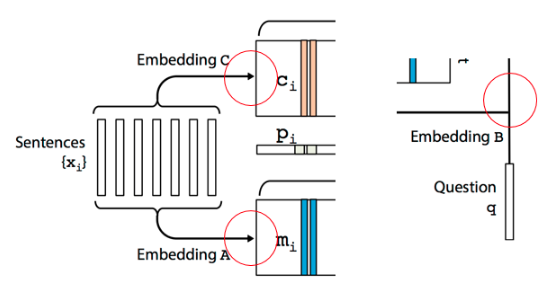

- ```Embedding A```: 스토리 임베딩 - 질문과의 매칭 유사도를 구하기 위한 임베딩
- ```Embedding B```: 질문 임베딩
- ```Embedding C```: 스토리 임베딩 - 예측을 위한 입력 임베딩

임베딩 A와 C는 서로 다르다. 

### 스토리 문장의 메모리 표현(Embeddng A) ⇒ 행렬 m
스토리 문장에 있는 단어들은 ```Embedding A```를 거쳐 각각의 임베딩 벡터로 임베딩된다. 

스토리 문장의 길이가 68, 임베딩 벡터의 차원이 50일 때, 68 길이의 스토리 문장을 ```Embedding A```에 입력해 얻는 행렬의 크기는 (68,50)이다. (배치 크기 고려하지 않을 때)

즉 Embedding A를 적용한 후의 결과는 (story_max_len, embed_size)이다. 

### 질문 문장의 메모리 표현(Embedding B) ⇒ 행렬 u
질문 문장에 있는 단어들은 ```Embedding B```를 거치면서 임베딩 벡터로 변환된다. 

질문 문장의 길이가 4, 임베딩 벡터의 차원이 50이면, (배치 크기를 고려하지 않을 때) 4의 길이를 가지는 질문 문장을 ```Embedding B```에 입력해 얻는 행렬의 크기는 (4, 50)이다. 

즉 Embedding B는 question_max_len의 길이를 가지는 질문 문장을 입력받아서 (question_max_len, embed_size)를 리턴한다.

### 스토리 문장과 질문 문장의 매칭 유사도 계산하기 ⇒ 행렬 p

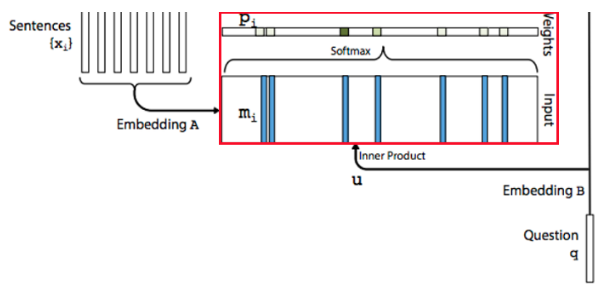
- ```m```: 스토리 문장을 ```Embedding A```에 거쳐서 얻은 결과 텐서
- ```u```: 질문 문장을 ```Embedding B```에 거쳐서 얻은 결과 텐서
- ```p```: ```m```과 ```u```의 매칭 유사도

텐서 ```m```과 ```u```의 매칭 유사도를 내적을 통해 구하고 softmax를 통과한다. 

$$p=Softmax(dot(m, u))$$

위 수식은 미분 가능한 soft attention이므로 End-to-End로 연결 가능하다. 
여기서 ```p```의 크기는 ```(max_story_len, question_max_len)```, 즉 행렬의 크기가 (68, 4)이다. 각 행렬의 원소가 의미하는 수치는 스토리에 있는 각 68개의 단어와 질문에 있는 각 4개의 단어에 대한 유사도를 의미한다. 

- 참고: [코사인 유사도와 그 계산 - 36](https://www.ibric.org/myboard/read.php?id=271138&Board=news)

### 스토리의 두 번째 메모리 표현(Embedding C) ⇒ 행렬 c
```Embedding C```는 예측을 위해 필요한 입력 임베딩이다. 임베딩 벡터의 차원 = 질문 문장의 길이

따라서 스토리 문장의 길이가 68, 질문의 길이가 4라면 68의 길이를 가지는 스토리 문장의 ```Embedding C```에 입력해 얻는 텐서의 크기는 (68, 4)이다. Embedding C는 story_max_len의 길이를 가지는 스토리 문장을 입력받아서 (story_max_len, question_max_len)를 리턴한다. 

행렬 ```c```와 ```p```의 크기는 동일함에 유의하자.

### 매칭 유사도 + 스토리 표현 + 질문 표현

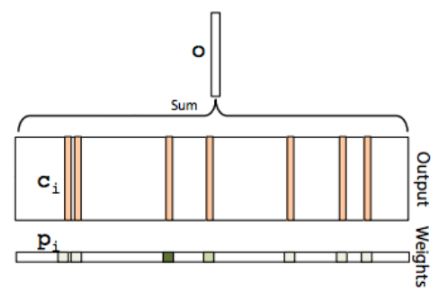

예측에 사용되는 출력 행렬 ```o```는 매칭 유사도 ```p```와 스토리 표현 ```c```를 더해 준다. 이 때 출력 행렬 ```o```의 크기는 (story_max_len, question_max_len), 즉 (68, 4)의 크기이다. 

$$o = add(c, p)$$

행렬 ```o``` 에는 스토리와 질문의 매칭 유사도 ```p```와 스토리 표현 ```c```이 포함되어 있다. 

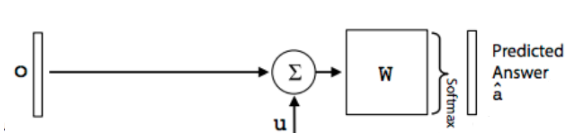

질문에 대한 임베딩은 이전에 매칭 유사도를 위해 만들었던 행렬 ```u```를 다시 사용한다. 여기서는 출력 벡터 ```o```와 질문 행렬 ```u```를 연결(concatenate)한다. 

그러나 출력 벡터 ```o```의 크기는 (68, 4)이고, 질문 행렬 ```u```의 크기는 (4, 50)이므로 서로 크기가 안 맞기 때문에 출력 벡터 ```o```의 크기를 (4, 68)로 변경한 후 두 행렬을 연결한다.

$$t = concat(o, u)$$

연결된 행렬을 ```t```라고 하면 이 행렬의 크기는 (4, 118)이다. 

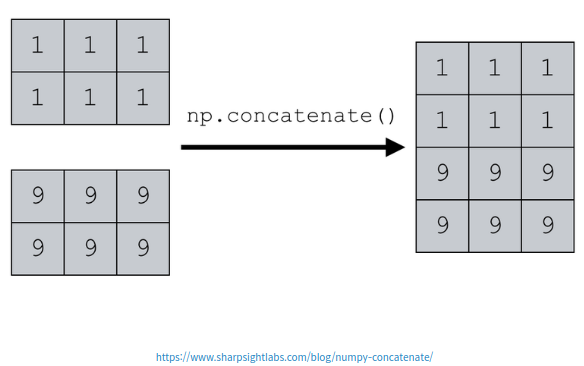

메모리 네트워크는 만들어진 최종 행렬 ```t```에 LSTM을 거치게 하고, LSTM의 출력을 Dense(완전연결층)를 거치게 한 뒤에 Softmax를 통해 답안을 예측하게 한다.

$$Predicted Answer = Softmax(Dense(LSTM(t)))$$

이 연산을 $W$로 요약하면 아래의 식과 같다.

$$Predicted Answer = Softmax(W(t))$$

이 내용은 프로젝트에서 구현을 통해 다시 확인할 것이다. Memory Network와 비교하면서 개념을 다져보자. 개념적으로 같은 역할을 하는 부분은 색깔도 동일하게 그려져 있다.  

## 13-6. 메모리 네트워크의 발전
- End-to-End Memory Network 이후, 추론을 가능하게 하는 모델의 발전

다음 링크는 paperwithcode.com에서 찾아볼 수 있는 bAbI 태스크의 리더보드이다. 2015년도의 End-to-End Memory Network 이후 몇 가지 모델들이 크게 개선된 성능을 보이고 있고, 이후로는 눈에 띄는 성능개선이 없어 보인다.

- [bAbI 태스크의 리더보드](https://paperswithcode.com/sota/question-answering-on-babi)

후속 모델들이 End-to-End Memory Network 모델 이후 성능개선을 이루는 포인트는 크게 아래 3가지이다.

- Recurrent 구조의 개선
- Attention 구조의 개선
- 메모리 관리 구조의 개선

### Recurrent 구조의 개선 - RRN

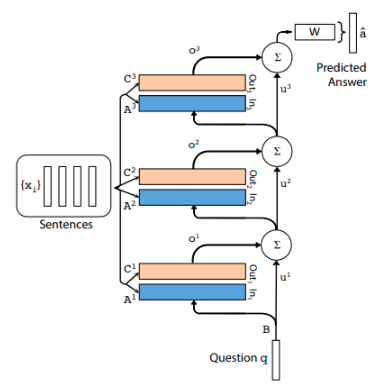

위 그림에서는 End-to-End Memory Network의 레이어들이 RNN처럼 3 step에 걸쳐 recurrent하게 반복하고 있다. Context에 해당하는 문장들을 하나씩 쪼개서 넣고 이전 레이어의 출력이 다음 레이어의 입력이 되는 recurrent한 구조로 구현을 하면 마치 외부 메모리를 가진 RNN처럼 동작한다. 이런 구조가 End-to-End Memory Network에서의 Multi-hop의 추론 작업 성능을 크게 개선하는 것으로 알려져 있다. 

#### Recurrent Relational Networks
[Recurrent Relational Networks(이하 RRN)](https://arxiv.org/pdf/1711.08028.pdf)는 2017년도에 발표된 [Relation Network](https://arxiv.org/pdf/1706.01427.pdf)의 개념을 적극 도입하여, End-to-End Memory Network 모델 구조를 확장하였다. 

End-to-End Memory Network는 레이어간 recurrency가 순차적으로 발생한다. 즉 이전 레이어의 출력이 다음 레이어의 입력이 되기 때문에 한 레이어의 입력에는 직전 레이어의 출력만 반영된다. 이는 RNN의 약점을 그대로 가지고 있는 형태이다. 

RRN은 모든 레이어간 relation을 전부 반영하도록 Message passing 개념을 적용했다. 

- Message passing 연결의 수식: $mt_{ij} = f(h_i^{t-1}, h_j^{t-1})$

따라서 노드가 3개라면 아래와 같은 형태로 확장된다

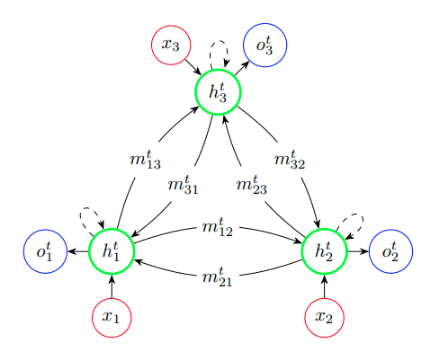

이런 차이는 bAbI task의 평균 오류율을 0.46% 정도로 크게 줄였다. 2017년 이후, bAbI task는 더이상 어려운 데이터셋이 아닌 걸로 취급되어, [Pretty-CLEVR 데이터셋](https://cs.stanford.edu/people/jcjohns/clevr/)이 Multi-hop reasoning을 위한 새로운 벤치마크 셋으로 활용되고 있다. 

### Attention 구조의 개선 - STM
리더보드에서 확인 가능한 2020년 현재의 SOTA 모델은 [Self-Attentive Associative Memory](https://arxiv.org/pdf/2002.03519v3.pdf)에서 소개한 __STM(SAM-based Two-memory Model)__ 이다. 이것은 SAM(Self-Attentive Associative Memory)을 기반으로 한다.

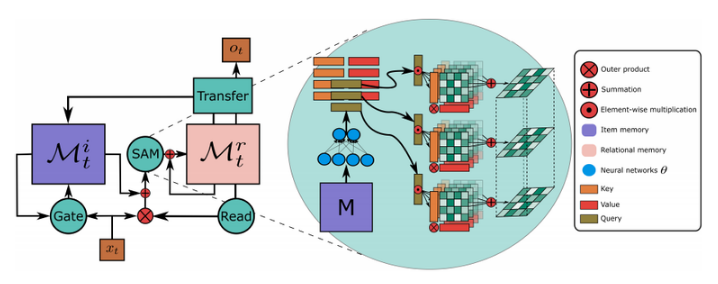

위 그림의 왼쪽 부분이 2개의 메모리 영역과 1개의 SAM으로 이루어진 STM 모델이고, 오른쪽이 SAM을 확대한 구조이다. 

이 모델에서는 outer-product를 사용해 input vector의 representation 사이의 relation을 표현하는 구조를 가진다. 그래서 네트워크의 이름이 SAM(Self-Attentive Associative Memory)이다. (일반적으로는 dot-product attention 기반의 self-attention을 사용함)

모든 노드 간 relation을 다 보게 하되 이것을 별도의 메모리에 보관하는 방식으로 정교하게 관리한다. 이런 방식으로 평균 오류율을 0.39%까지 떨어뜨리며 RRN 대비 근소한 성능 우위를 확인할 수 있다. 

### 메모리 관리 구조의 개선
메모리 관리 구조 개선을 통해 성능을 극대화시킨 사례는 DNC의 사례에서 볼 수 있다. DNC는 NTM과 달리 메모리 영역에서 물리적으로 가까우면 내용적으로 가깝게 배치되도록 안배하는 로직을 추가하고 메모리 영역 뒷단에서 메모리 영역간 관계를 별도로 관리하는 부분을 추가했다. (DNC의 D 영역 참고)

그러나 후속 연구를 통해 번거롭게 메모리를 관리하는 것보다 아이템간 relation을 제너럴하게 관리하는 relation network 계열의 접근이 단순하며서도 효율적이라는 것이 밝혀져 초창기 버전의 DNC는 잘 사용하지 않는다. 